### Use this Jupyter Notebook as a guide to run your trained model in inference mode

created by Anton Morgunov

inspired by [tensorflow object detection API tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#exporting-a-trained-model)

Your first step is going to specify which unit you are going to work with for inference. Select between GPU or CPU and follow the below instructions for implementation.

In [1]:
import sys, os

os.chdir('../..')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
from config import PROJECT_ROOT

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
# other import
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

Next you will import import scripts that were already provided by Tensorflow API. **Make sure that Tensorflow is your current working directory.**

In [4]:
# importing all scripts that will be needed to export your model and use it for inference
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

Now you can import and build your trained model:

In [5]:
# NOTE: your current working directory should be Tensorflow.

model_dir = "alignment/efficientdet_d1_coco17_tpu-32"

checkpoint_dir = os.path.join(model_dir, 'checkpoint')

config_path = os.path.join(model_dir, 'pipeline.config')


In [6]:
# do not change anything in this cell
configs = config_util.get_configs_from_pipeline_file(config_path) # importing config
model_config = configs['model'] # recreating model config
detection_model = model_builder.build(model_config=model_config, is_training=False) # importing model

In [7]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(checkpoint_dir, 'ckpt-0')).expect_partial()

Next, path to label map should be provided. Category index will be created based on labal map file

In [8]:
label_map_file = "datasets/COOP/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(label_map_file,use_display_name=True)

Now, a few supporting functions will be defined

In [9]:
def detect_fn(image):
    """
    Detect objects in image.
    
    Args:
      image: (tf.tensor): 4D input image
      
    Returs:
      detections (dict): predictions that model made
    """

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [10]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

**Next function is the one that you can use to run inference and plot results an an input image:**

In [11]:
def inference_with_plot(path2images, box_th=0.25):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """
    for image_path in path2images:

        print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=5)

        plt.figure(figsize=(15,10))
        plt.imshow(image_np_with_detections)
        print('Done')
    plt.show()

Next, we will define a few other supporting functions:

In [12]:
def nms(rects, thd=0.5):
    """
    Filter rectangles
    rects is array of oblects ([x1,y1,x2,y2], confidence, class)
    thd - intersection threshold (intersection divides min square of rectange)
    """
    out = []

    remove = [False] * len(rects)

    for i in range(0, len(rects) - 1):
        if remove[i]:
            continue
        inter = [0.0] * len(rects)
        for j in range(i, len(rects)):
            if remove[j]:
                continue
            inter[j] = intersection(rects[i][0], rects[j][0]) / min(square(rects[i][0]), square(rects[j][0]))

        max_prob = 0.0
        max_idx = 0
        for k in range(i, len(rects)):
            if inter[k] >= thd:
                if rects[k][1] > max_prob:
                    max_prob = rects[k][1]
                    max_idx = k

        for k in range(i, len(rects)):
            if (inter[k] >= thd) & (k != max_idx):
                remove[k] = True

    for k in range(0, len(rects)):
        if not remove[k]:
            out.append(rects[k])

    boxes = [box[0] for box in out]
    scores = [score[1] for score in out]
    classes = [cls[2] for cls in out]
    return boxes, scores, classes


def intersection(rect1, rect2):
    """
    Calculates square of intersection of two rectangles
    rect: list with coords of top-right and left-boom corners [x1,y1,x2,y2]
    return: square of intersection
    """
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]));
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]));
    overlapArea = x_overlap * y_overlap;
    return overlapArea


def square(rect):
    """
    Calculates square of rectangle
    """
    return abs(rect[2] - rect[0]) * abs(rect[3] - rect[1])

**Next function is the one that you can use to run inference and save results into a file:**

In [13]:
def inference_as_raw_output(path2images,
                            box_th=0.25,
                            nms_th=0.5,
                            to_file=False,
                            data=None,
                            path2dir=False):
    """
   Function that performs inference and return filtered predictions

   Args:
     path2images: an array with pathes to images
     box_th: (float) value that defines threshold for model prediction. Consider 0.25 as a value.
     nms_th: (float) value that defines threshold for non-maximum suppression. Consider 0.5 as a value.
     to_file: (boolean). When passed as True => results are saved into a file. Writing format is
     path2image + (x1abs, y1abs, x2abs, y2abs, score, conf) for box in boxes
     data: (str) name of the dataset you passed in (e.g. test/validation)
     path2dir: (str). Should be passed if path2images has only basenames. If full pathes provided => set False.

   Returs:
     detections (dict): filtered predictions that model made
   """

    print(f'Current data set is {data}')
    print(f'Ready to start inference on {len(path2images)} images!')
    
    results = []
    
    for image_path in tqdm(path2images):

        if path2dir:  # if a path to a directory where images are stored was passed in
            image_path = os.path.join(path2dir, image_path.strip())

        image_np = load_image_into_numpy_array(image_path)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # checking how many detections we got
        num_detections = int(detections.pop('num_detections'))

        # filtering out detection in order to get only the one that are indeed detections
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        # defining what we need from the resulting detection dict that we got from model output
        key_of_interest = ['detection_classes', 'detection_boxes', 'detection_scores']

        # filtering out detection dict in order to get only boxes, classes and scores
        detections = {key: value for key, value in detections.items() if key in key_of_interest}

        if box_th:  # filtering detection if a confidence threshold for boxes was given as a parameter
            for key in key_of_interest:
                scores = detections['detection_scores']
                current_array = detections[key]
                filtered_current_array = current_array[scores > box_th]
                detections[key] = filtered_current_array

        if nms_th:  # filtering rectangles if nms threshold was passed in as a parameter
            # creating a zip object that will contain model output info as

            output_info = list(zip(detections['detection_boxes'],
                                   detections['detection_scores'],
                                   detections['detection_classes']
                                   )
                               )
            boxes, scores, classes = nms(output_info)

            detections['detection_boxes'] = boxes  # format: [y1, x1, y2, x2]
            detections['detection_scores'] = scores
            detections['detection_classes'] = classes
        
        image_h, image_w, _ = image_np.shape
        
        result = []
        for b, s, c in zip(detections['detection_boxes'], detections['detection_scores'], detections['detection_classes']):
            y1abs, x1abs = b[0] * image_h, b[1] * image_w
            y2abs, x2abs = b[2] * image_h, b[3] * image_w
            result.append({'bounding_box': np.array([x1abs, y1abs, x2abs, y2abs]), 'class': c + 1, 'score': s})

        if to_file and data:  # if saving to txt file was requested

            file_name = f'pred_result_{data}.txt'

            line2write = list()
            line2write.append(os.path.basename(image_path))

            with open(file_name, 'a+') as text_file:
                # iterating over boxes
                line2append = ','.join([str(item) for item in list2append])

                line2write.append(line2append)

                line2write = ' '.join(line2write)
                text_file.write(line2write + os.linesep)
        results.append(result)
    
    return results

In [14]:
test_images_dir = "datasets/COOP/padded (original)"

test_images = []
for img_path in os.listdir(test_images_dir):
    if img_path.endswith('.jpg'):
        img_path = os.path.join(test_images_dir, img_path)
        test_images.append(img_path)

## Test performance

In [35]:
a = [1, 2, 3]

In [17]:
results = inference_as_raw_output(test_images, box_th=0.25, nms_th=0, to_file=False, data='test')

  0%|          | 0/53 [00:00<?, ?it/s]

Current data set is test
Ready to start inference on 53 images!


100%|██████████| 53/53 [00:11<00:00,  4.66it/s]


In [15]:
test_images[0]

'datasets/COOP/padded (original)/img_61_padded.jpg'

In [16]:
%matplotlib inline

Running inference for datasets/COOP/padded (original)/img_61_padded.jpg... Done


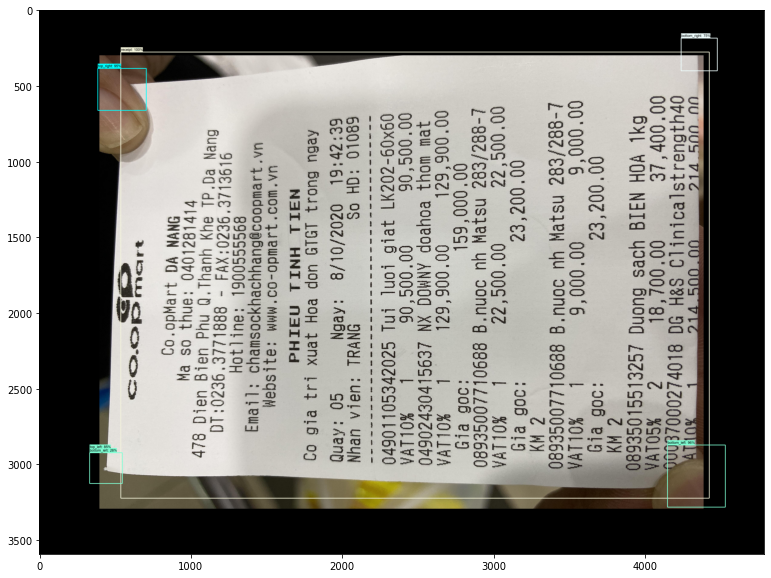

In [17]:
inference_with_plot([test_images[0]])

## Prespective Transform

In [18]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [19]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


In [20]:
def is_below(point_1, point_2):
    return True if point_1[1] > point_2[1] else False

In [21]:
def flip_to_vertical(points):
    if is_below(points['top_left'], points['top_right']) and is_below(points['bottom_left'], points['bottom_right']):
        return cv2.cv2.ROTATE_90_CLOCKWISE
    elif is_below(points['top_right'], points['top_left']) and is_below(points['bottom_right'], points['bottom_left']):
        return cv2.cv2.ROTATE_90_COUNTERCLOCKWISE
    else:
        return None

In [22]:
def get_transformed_image(img, prediction_results, category_index):
    points = {}
    for i, box in enumerate(prediction_results):
        name = category_index[box['class']]['name']
        if name != 'receipt':
            coords = np.array(np.hsplit(box['bounding_box'], 2)).mean(axis=0)
            points[name] = coords.astype(int)
        else:
            points[name] = box['bounding_box'].astype(int)
    four_points = np.array([points['top_left'], points['top_right'], points['bottom_left'], points['bottom_right']])
    img_transformed = four_point_transform(img, four_points)
    
    flip_arg = flip_to_vertical(points) 
    if flip_arg is not None:
        img_transformed = cv2.rotate(img_transformed, flip_arg) 
        
    return img_transformed

In [23]:
%matplotlib inline

In [24]:
import cv2

In [25]:
img_path = test_images[0]
img = plt.imread(img_path)
result = inference_as_raw_output([img_path], box_th=0.25, nms_th=0)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Current data set is None
Ready to start inference on 1 images!


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


In [26]:
category_index

{1: {'id': 1, 'name': 'top_left'},
 2: {'id': 2, 'name': 'top_right'},
 3: {'id': 3, 'name': 'bottom_left'},
 4: {'id': 4, 'name': 'bottom_right'},
 5: {'id': 5, 'name': 'receipt'}}

In [27]:
result

[{'bounding_box': array([ 540.42999366,  277.48797186, 4427.69248521, 3222.40508759]),
  'class': 5,
  'score': 0.9999961},
 {'bounding_box': array([4151.72723711, 2871.72320616, 4533.4635973 , 3281.5572592 ]),
  'class': 3,
  'score': 0.9640435},
 {'bounding_box': array([388.41995063, 385.41491995, 708.24114974, 662.55173197]),
  'class': 2,
  'score': 0.9537722},
 {'bounding_box': array([ 334.64933159, 2922.96744561,  550.49687613, 3125.41658771]),
  'class': 1,
  'score': 0.8505268},
 {'bounding_box': array([4241.24530274,  185.65247833, 4480.0813641 ,  401.01992784]),
  'class': 4,
  'score': 0.7523501},
 {'bounding_box': array([ 334.64933159, 2922.96744561,  550.49687613, 3125.41658771]),
  'class': 3,
  'score': 0.25939873}]

In [28]:
points = {}
for i, box in enumerate(result):
    name = category_index[box['class']]['name']
    if name != 'receipt':
        coords = np.array(np.hsplit(box['bounding_box'], 2)).mean(axis=0)
        points[name] = coords.astype(int)
    else:
        points[name] = box['bounding_box'].astype(int)

In [29]:
def is_completed_prediction(prediction_result, category_index):
    detected_classes = set([box['class'] for box in prediction_result])
    return True if detected_classes == set(category_index.keys()) else False

In [30]:
points

{'receipt': array([ 540,  277, 4427, 3222]),
 'bottom_left': array([ 442, 3024]),
 'top_right': array([548, 523]),
 'top_left': array([ 442, 3024]),
 'bottom_right': array([4360,  293])}

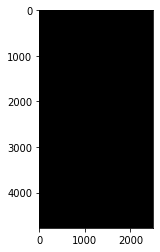

In [34]:
img_transformed = get_transformed_image(img, result, category_index)
plt.imshow(img_transformed)
plt.show()

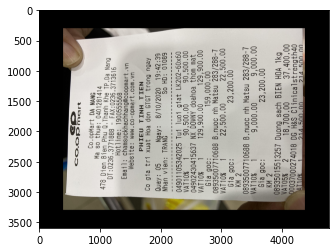

In [32]:
plt.imshow(img)

In [52]:
len(results[i])

5

In [62]:
len(test_images)

53

In [74]:
images_list = []
for i, img_path in enumerate(test_images):
    print(img_path)
    if is_completed_prediction(results[i], category_index):
        img = plt.imread(img_path)
        img_transformed = get_transformed_image(img, results[i], category_index)
        dst_path = os.path.join('datasets', 'COOP', 'transformed', os.path.split(img_path)[1])
        plt.imsave(dst_path, img_transformed)

datasets/COOP/test/img_61_padded.jpg
datasets/COOP/test/img_62_padded.jpg
datasets/COOP/test/img_147_padded.jpg
datasets/COOP/test/img_123_padded.jpg
datasets/COOP/test/img_96_padded.jpg
datasets/COOP/test/img_95_padded.jpg
datasets/COOP/test/img_157_padded.jpg
datasets/COOP/test/img_153_padded.jpg
datasets/COOP/test/img_51_padded.jpg
datasets/COOP/test/img_79_padded.jpg
datasets/COOP/test/img_84_padded.jpg
datasets/COOP/test/img_45_25_12_padded.jpg
datasets/COOP/test/img_154_padded.jpg
datasets/COOP/test/img_92_padded.jpg
datasets/COOP/test/img_40_25_12_padded.jpg
datasets/COOP/test/img_104_padded.jpg
datasets/COOP/test/img_59_25_12_padded.jpg
datasets/COOP/test/img_101_padded.jpg
datasets/COOP/test/img_54_padded.jpg
datasets/COOP/test/img_76_25_12_padded.jpg
datasets/COOP/test/img_2_padded.jpg
datasets/COOP/test/img_2_25_12_padded.jpg
datasets/COOP/test/img_70_25_12_padded.jpg
datasets/COOP/test/img_33_25_12_padded.jpg
datasets/COOP/test/img_111_padded.jpg
datasets/COOP/test/img_107_

import ipyplot

ipyplot.plot_images(images_list, max_images=50, img_width=200)
